The Chicago bike data seems to be in good condition and contains lots of entries and with lots of useful data.
The data used is from **January 2021** up to **December 2021**.

**NOTE**: The notebook is designed as a guide for creating the project in RStudio/R-GUI.


- Open RStudio/R-GUI.
- Install the tidyverse package (if not already installed)
- Then call the tidyverse and tidyr for data cleaning functions.
- Although other packages are already included in the tidyverse, its good practice to call the libraries.

In [1]:
install.packages("tidyverse")
library(tidyverse)
library(tidyr)

**DATA LOADING**: Then the data is loaded into RStudio as dataframes for further steps.
* Create a datasets folder in the RStudio project.
* Upload the zipped 12 csv files into the folder.
* Read all months csv/excel from local computer folder/kaggle dataset path/url into datframe with the read_csv/read_excel function with the path set to the project dataset folder that was created.
* Bind all the datframes into a single one for compiled 2021 yearly data.

In [2]:
library(readr)

tripdata_202112 <- read_csv("../input/chicago-bike-share-data-2021/202112-divvy-tripdata.csv")
tripdata_202111 <- read_csv("../input/chicago-bike-share-data-2021/202111-divvy-tripdata.csv")
tripdata_202110 <- read_csv("../input/chicago-bike-share-data-2021/202110-divvy-tripdata.csv")
tripdata_202109 <- read_csv("../input/chicago-bike-share-data-2021/202109-divvy-tripdata.csv")
tripdata_202108 <- read_csv("../input/chicago-bike-share-data-2021/202108-divvy-tripdata.csv")
tripdata_202107 <- read_csv("../input/chicago-bike-share-data-2021/202107-divvy-tripdata.csv")
tripdata_202106 <- read_csv("../input/chicago-bike-share-data-2021/202106-divvy-tripdata.csv")
tripdata_202105 <- read_csv("../input/chicago-bike-share-data-2021/202105-divvy-tripdata.csv")
tripdata_202104 <- read_csv("../input/chicago-bike-share-data-2021/202104-divvy-tripdata.csv")
tripdata_202103 <- read_csv("../input/chicago-bike-share-data-2021/202103-divvy-tripdata.csv")
tripdata_202102 <- read_csv("../input/chicago-bike-share-data-2021/202102-divvy-tripdata.csv")
tripdata_202101 <- read_csv("../input/chicago-bike-share-data-2021/202101-divvy-tripdata.csv")


In [3]:
library(dplyr)

tripdata_2021 <- bind_rows(tripdata_202101, tripdata_202102, tripdata_202103, tripdata_202104, tripdata_202105, tripdata_202106, tripdata_202107, tripdata_202108, tripdata_202109, tripdata_202110, tripdata_202111, tripdata_202112)

Inspect the general datatypes and structure of the combined dataframe.

In [4]:
glimpse(tripdata_2021)

**DATA PREPARATION & CLEANUP**:
* Drop the NA values from all the important anlysis columns that are: ride_id, started_at, ended_at, member_casual.

In [5]:
tripdata_2021 <- drop_na(tripdata_2021, ride_id, started_at, ended_at, member_casual)

New column values can be inserted into the dataframe by two main methods: *simple column assignment* and *mutate() function*.
* A month column is added by simple assignment. The format function changes the date format into the month string.
* A weekday column is added by simple column assignment. The format function extracts the weekday string from the date.

In [6]:
library(lubridate)

tripdata_2021$month <- format(as.Date(tripdata_2021$started_at), "%B")

tripdata_2021$day_of_week <- format(as.Date(tripdata_2021$started_at), "%A")

* A pipeline with the mutate function creates a new ride_length column. The timediff() function returns the ride length in number of seconds (i.e, as drtn interval datatype).
* By simple column calcualtion, the ride_length column is updated to time datatype by seconds_to_period() function.

In [7]:
tripdata_2021 <- tripdata_2021 %>% mutate(ride_length = difftime(ended_at,started_at))

tripdata_2021$ride_length <- hms::hms(seconds_to_period(tripdata_2021$ride_length))

* All the negative ride_lengths rows(if any) are deleted from the table.

In [8]:
tripdata_2021 <- tripdata_2021[!(as.numeric(tripdata_2021$ride_length) < 0),]

* The geosphere library is installed(if not already installed). And then the package is loaded.
* A new column ride_distance is addd by computing the geographical distances in metres from start point to end point(determined by latitude and longitude).
* This distance is converted to km by dividing by 1000.

In [9]:
install.packages("geosphere")
library(geosphere)

tripdata_2021$ride_distance <- distGeo(matrix(c(tripdata_2021$start_lng, tripdata_2021$start_lat), ncol = 2), matrix(c(tripdata_2021$end_lng, tripdata_2021$end_lat), ncol = 2))

tripdata_2021$ride_distance <- tripdata_2021$ride_distance/1000

* A ride_speed column is added by dividing the ride_distance by the ride_length(converted to number of hours).

In [10]:
tripdata_2021$ride_speed <- (tripdata_2021$ride_distance)/(as.numeric((tripdata_2021$ride_length), units="hours"))

Inspect the general datatypes and structure of the combined dataframe.

In [11]:
glimpse(tripdata_2021)

**DESCRIPTIVE ANALYSIS AND VISUALIZATIONS**:

**1)**  ***Over year user-type stats***:
* A pipeline is created to sumaarize the avg ride length, distance and the number of rides taken by members and casuals over the year.
* The n() function counts the number of entries and register sit as the ride count.
* The mean distance is calculated by omiting all NA values to avoid NaN values in the average calculated.
* The average ride length are calculated by summarizing the mean of the grouped member_casual column.

In [12]:
#1
user_type_stat <- tripdata_2021 %>%
            group_by(member_casual) %>%
            summarise(ride_cnt = n(), mean_distance = mean(!is.na(ride_distance)), mean_time = mean(ride_length)) %>%
            arrange(member_casual)


The summarised data can be viewed to find out patterns, but its best practice to visualize too.

In [14]:
View(user_type_stat)

* Each of the stats are visualized by the ggplot2 library.

In [16]:
library(ggplot2)

num_rides <- ggplot(user_type_stat) +
            geom_col(mapping = aes(x = member_casual, y = ride_cnt, fill = member_casual), show.legend = FALSE) +
            labs(title = "Number of rides by User Type", x = "User Type", y = "Number of rides")

library(lubridate)
mean_time_plot <- ggplot(user_type_stat) + 
                geom_col(mapping = aes(x = member_casual, y = hms::hms(seconds_to_period(mean_time)), fill = member_casual), show.legend = FALSE) + 
                labs(title = "Mean travel time by User type", x = "User Type", y = "Mean time in sec")

mean_distance_plot <- ggplot(user_type_stat) + 
                    geom_col(mapping = aes(x = member_casual, y = as.numeric(mean_distance), fill = member_casual), show.legend = FALSE) +
                    labs(title = "Mean travel distance by User type", x = "User Type", y = "Mean distance In km")


* The package gridExtra is installed as it contains the grid.arrange function, that places different plot objects in a grid specified by either the number of rows or/and columns.

In [17]:
install.packages("gridExtra")
library(gridExtra)

grid.arrange(num_rides, mean_time_plot, mean_distance_plot, ncol = 3)

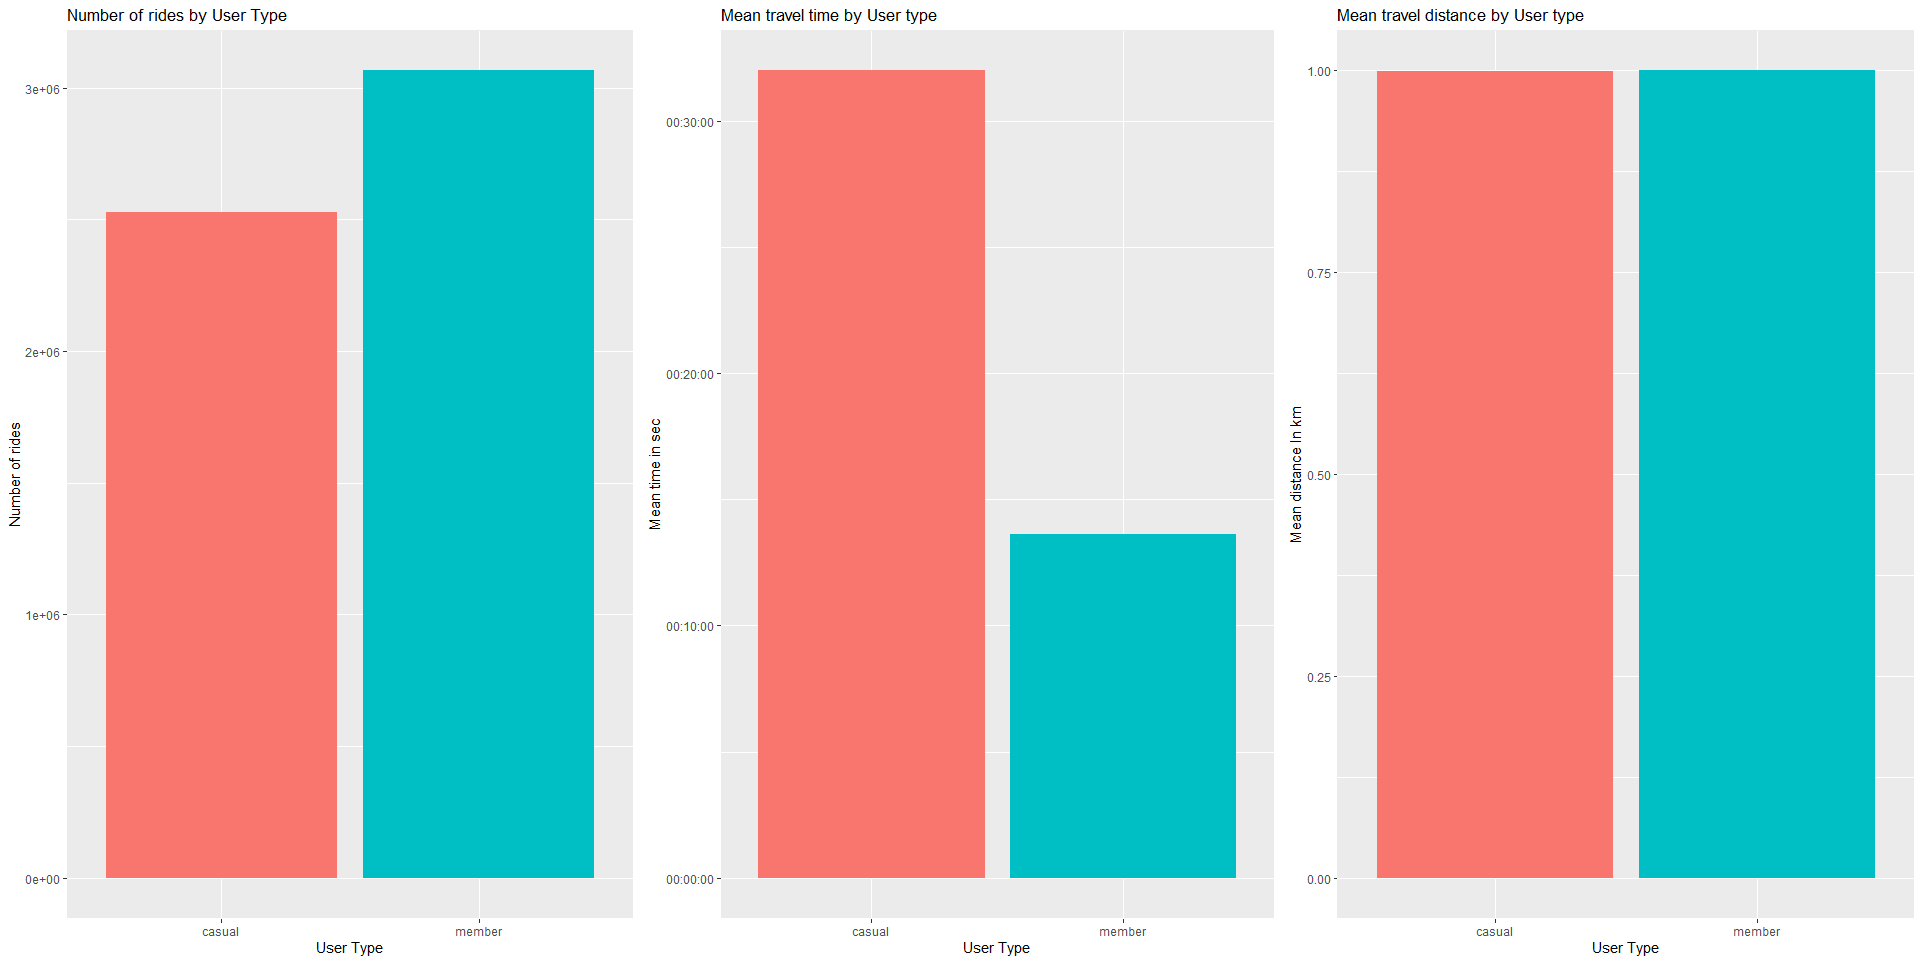

**Conclusions :**
* It seems that the casual users travel the same average distance than the member users, but they have much longer rides, that would indicate a more leisure oriented usage vs a more "public transport" or pragmatic use of the bikes by the annual members.

**2)** ***Over months user-type stats:***
* A pipeline is created to summarize the avg ride length, distance and the number of rides taken by members and casuals over the year.
* The months field previously created is in string 'mmmm'('%B') format, but for orderly printing in viz, a number format is needed, thus a pipeline is created with the mutate function creating the '%m' numeric format month.
* The ride count, avg ride distance and avergae ride length all are created with the same consideration as in the previous stat.
* The results are then arranged first by the numeric format month and then by user type.

In [18]:
usertype_month_stat <- tripdata_2021 %>%
                mutate(month_num = format(as.Date(started_at), "%m")) %>%
                group_by(month_num, member_casual) %>%
                summarise(ride_cnt = n(), mean_distance = mean(!is.na(ride_distance)), mean_time = mean(ride_length), .groups = "drop") %>%
                arrange(month_num , member_casual)

The summarised data can be viewed to find out patterns, but its best practice to visualize too.

In [19]:
View(usertype_month_stat)

* The individual plots for each summarized value is in a side-by-side column graph (i.e, a *dodged position*, instead of the default *stacked position*.)

In [20]:
num_rides <- ggplot(data = usertype_month_stat, mapping = aes(x = month_num, y = ride_cnt, fill = member_casual)) +
            geom_col(position = "dodge", show.legend = FALSE) +
            labs(title = "Number of rides by User Type", x = "Month", y = "Number of rides")

mean_time_plot <- ggplot(data = usertype_month_stat, mapping = aes(x = month_num, y = hms::hms(seconds_to_period(mean_time)), fill = member_casual)) + 
                geom_col(position = "dodge", show.legend = FALSE) + 
                labs(title = "Mean travel time by User type", x = "Month", y = "Mean time in sec")

mean_distance_plot <- ggplot(data = usertype_month_stat, mapping = aes(x = month_num, y = as.numeric(mean_distance), fill = member_casual)) + 
                    geom_col(position = "dodge") +
                    labs(title = "Mean travel distance by User type", x = "Month", y = "Mean distance In km")

* The viz's are displayed in a row-wise grid with the grid.arrnage function.

In [21]:
grid.arrange(num_rides, mean_time_plot, mean_distance_plot, nrow = 3)

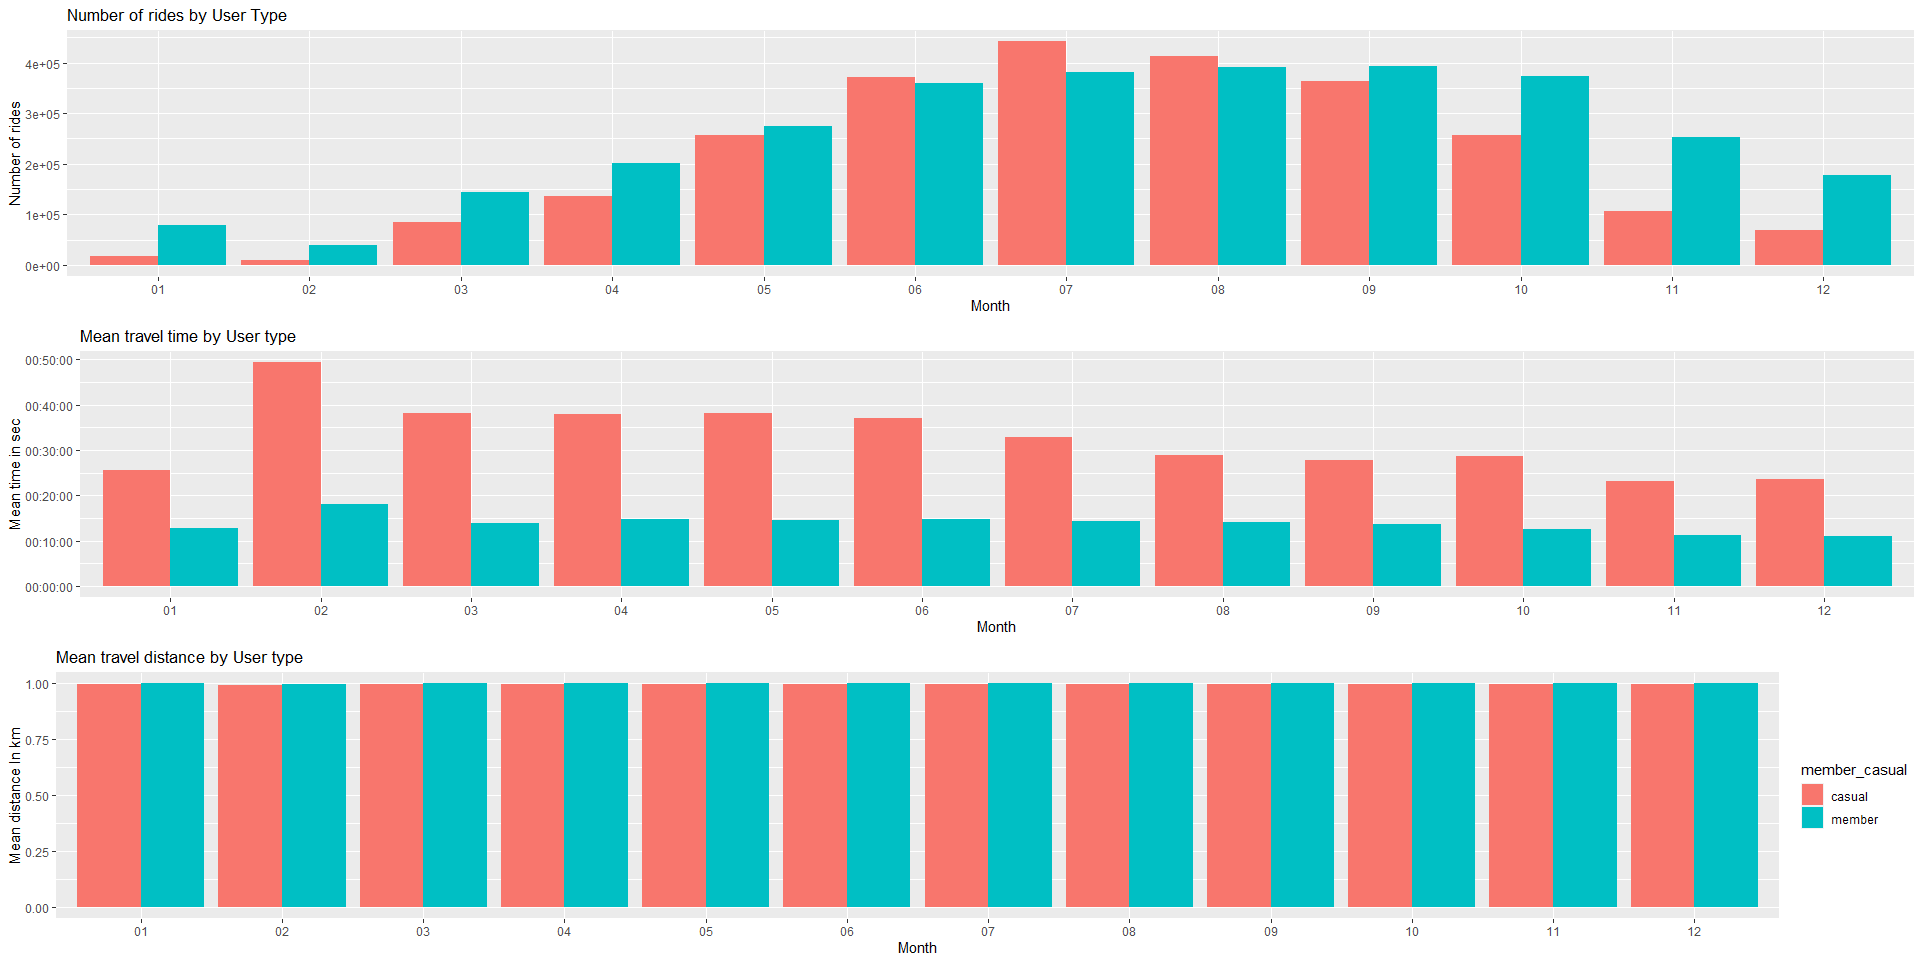

**Conclusions :**
* The same observations about the ride distance can be made.
* The viz's have the same conclusions as that made from the Tableau plots of the number of rides and the avg ride length of user types over months of year.

**3)** ***Over weekdays user-type stats:***
* A pipeline is for the same three summarized observations from data.
* For the same string arranging discrepancies, the numeric weekday umber column is added via the pipeline by the mutate function.

In [22]:
usertype_weekday_stat <- tripdata_2021 %>%
                    mutate(day_week = wday(started_at)) %>% 
                    group_by(day_week, member_casual) %>%
                    summarise(ride_cnt = n(), mean_distance = mean(!is.na(ride_distance)), mean_time = mean(ride_length), .groups = "drop") %>%
                    arrange(day_week , member_casual)

* Individual plots are created and the arranging of the plot objects is done side-by-side in 3 columns.

In [23]:
num_rides <- ggplot(data = usertype_weekday_stat, mapping = aes(x = day_week, y = ride_cnt, fill = member_casual)) +
            geom_col(position = "dodge", show.legend = FALSE) +
            labs(title = "Number of rides by User Type", x = "Days [Sunday=1]", y = "Number of rides")

mean_time_plot <- ggplot(data = usertype_weekday_stat, mapping = aes(x = day_week, y = hms::hms(seconds_to_period(mean_time)), fill = member_casual)) + 
                geom_col(position = "dodge", show.legend = FALSE) + 
                labs(title = "Mean travel time by User type", x = "Days", y = "Mean time in sec")

mean_distance_plot <- ggplot(data = usertype_weekday_stat, mapping = aes(x = day_week, y = as.numeric(mean_distance), fill = member_casual)) + 
                    geom_col(position = "dodge") +
                    labs(title = "Mean travel distance by User type", x = "Days", y = "Mean distance In km")

grid.arrange(num_rides, mean_time_plot, mean_distance_plot, ncol = 3)

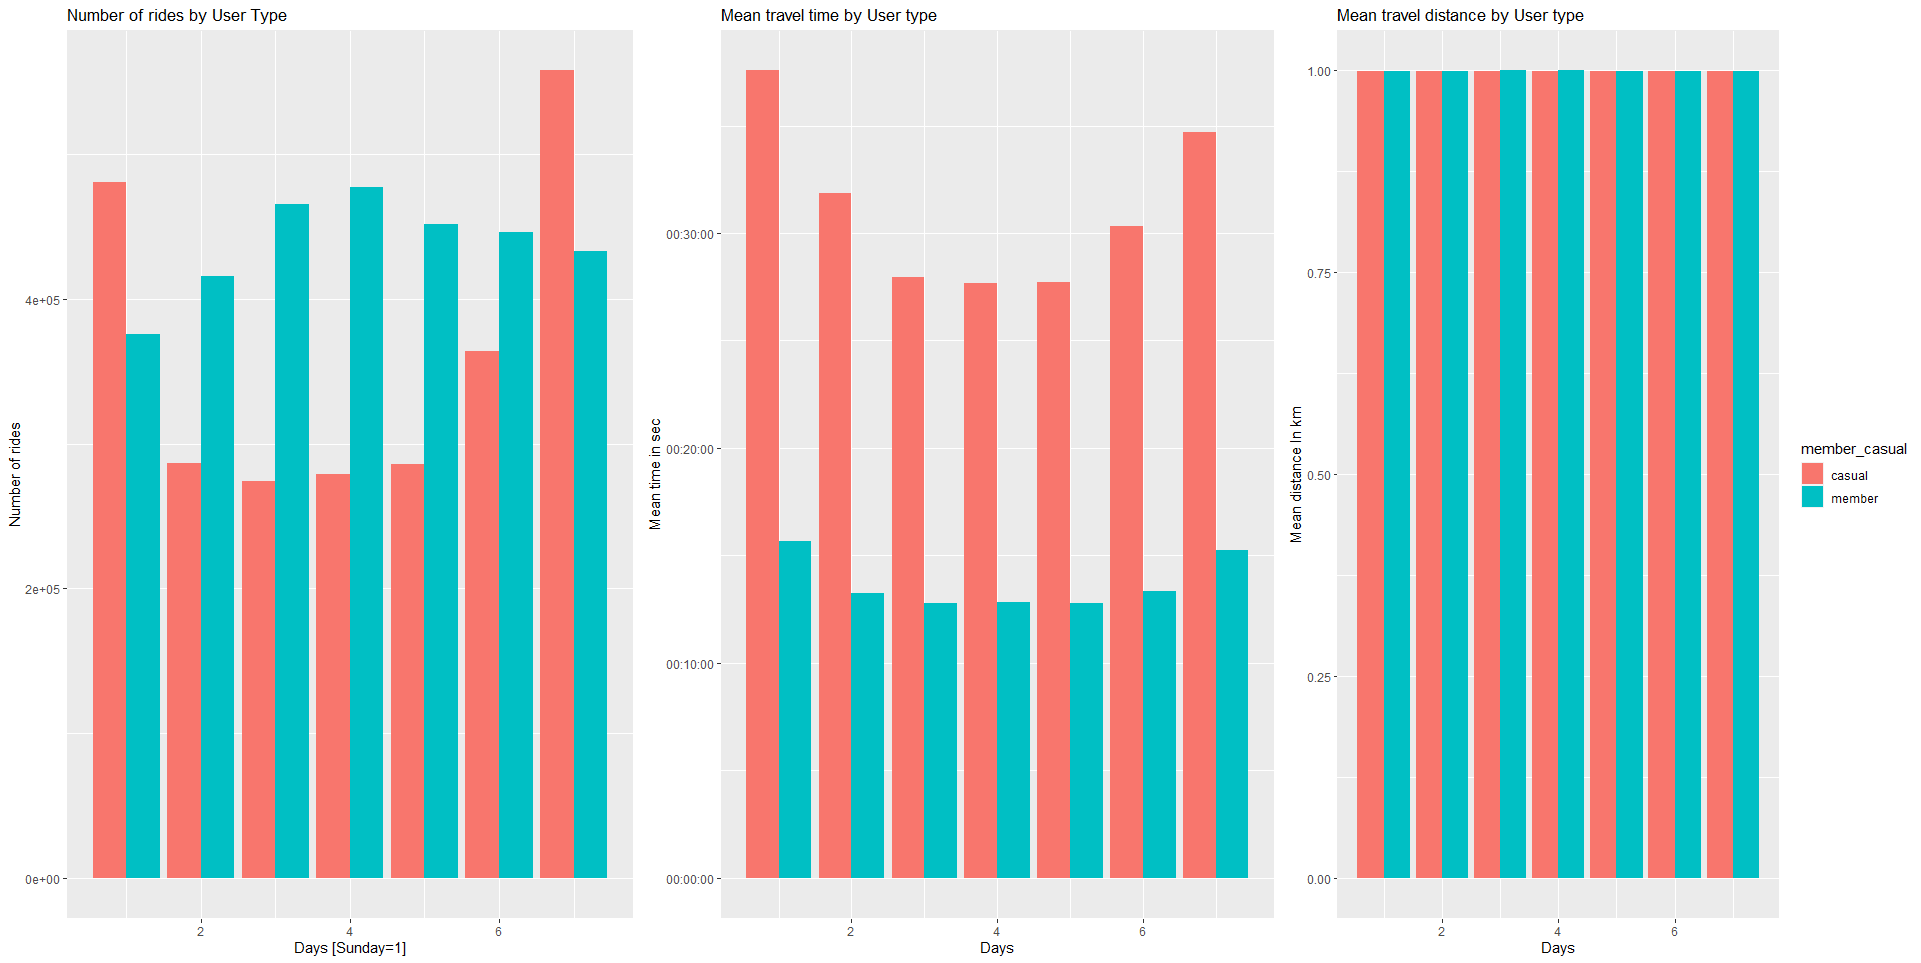

**Conclusions :**
* This idea of public transport v/s leisure usage is reinforced by the fact that annual users(i.e, members) have a very stable use of the service during the week, but the casual users are more of a weekend user.

**4)** ***Over year ride-type stats:***
* The whole pipeline visualizes the total rides taken by each ride type and each by the user type.

In [24]:
bike_type_stat <- tripdata_2021 %>%
                group_by(member_casual,rideable_type) %>%
                summarise(total_rides = n(), .groups = "drop")  %>%
                ggplot()+
                geom_col(aes(x = member_casual,y = total_rides, fill = rideable_type), position = "dodge") + 
                labs(title = "Bike type by user type",x="User type",y=NULL, fill="Bike type") +
                theme(legend.position="top")

bike_type_stat

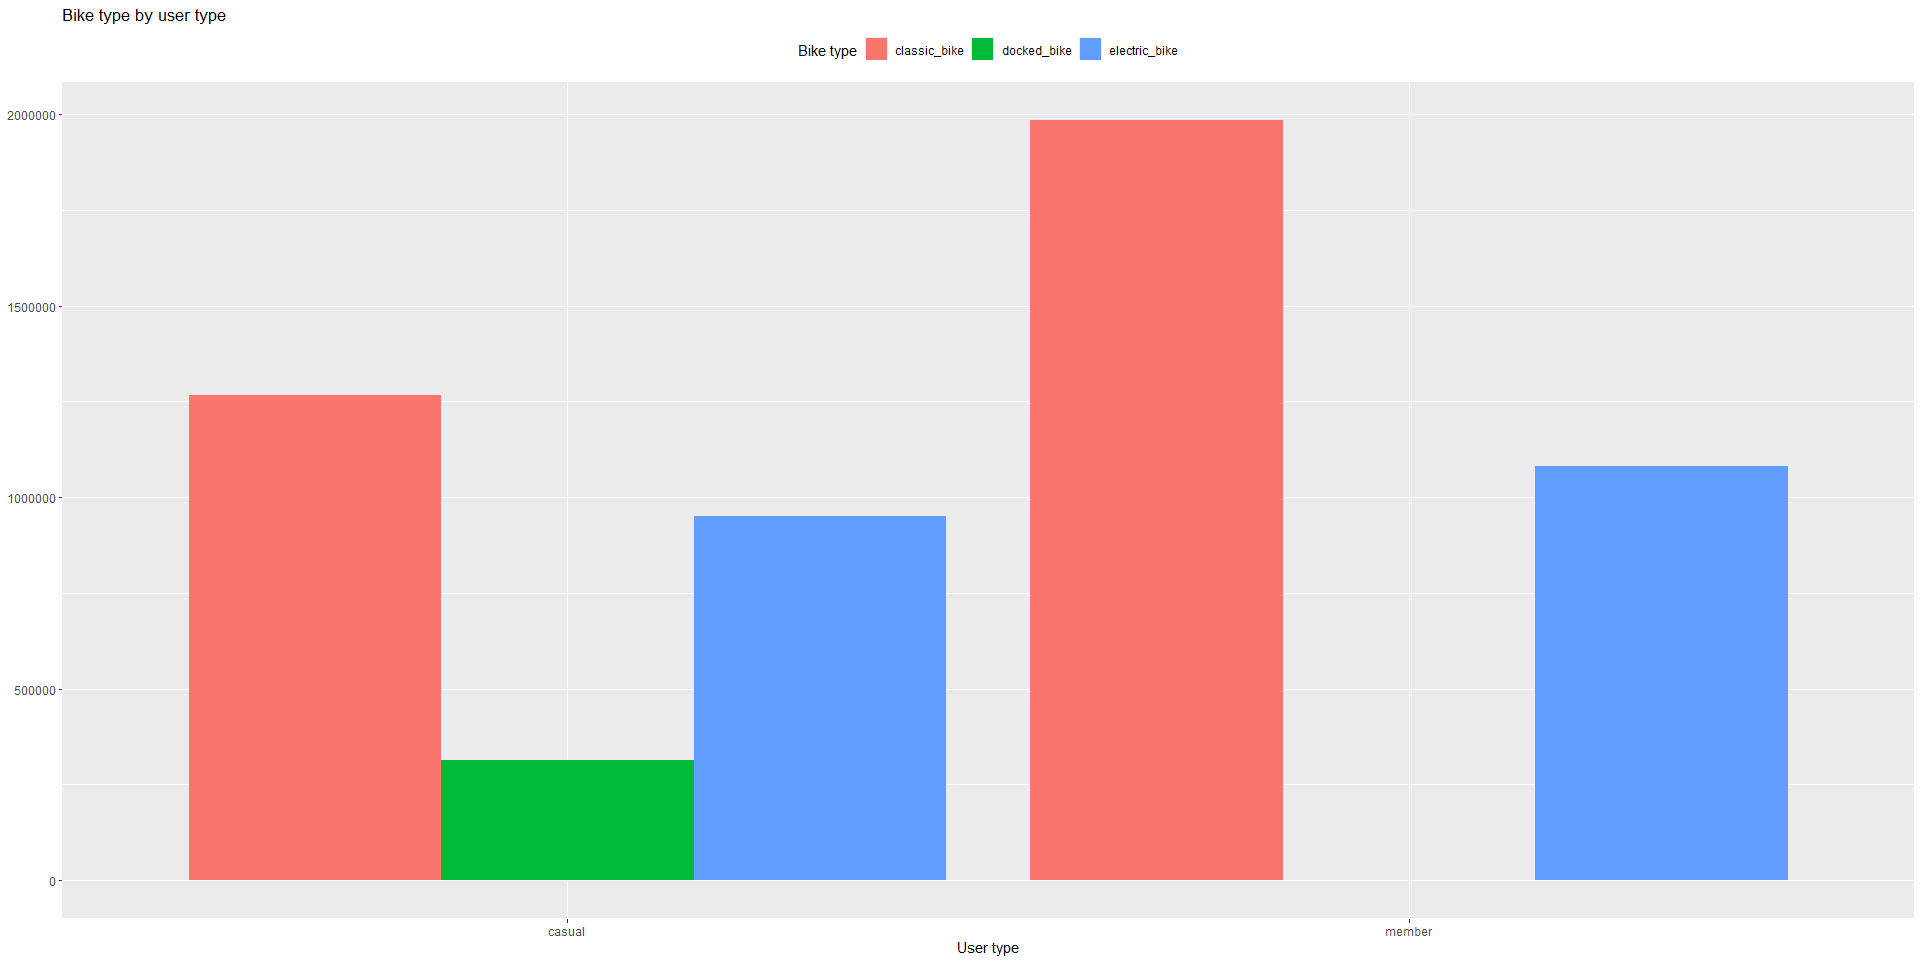

**Conclusions :**
* Here we can see that the casual users use both types of bikes for their rides, but the annual members show a clear preference for the classic bikes, which makes sense given the short duration of their rides.
* Both users use classic bike more than the electric bike, and the docked bike is just used by casual users.

**5)** ***Over week ride-type stats***
* As the docked bikes are not used by the members and casuals use them very less, they are filtered out from the pipe.
* Number of each bike type ride grouped the user type over the average week is calculated and visualized by the pipe.

In [25]:
weekday_biketype_stat <- tripdata_2021 %>%
                        filter(!rideable_type=="docked_bike") %>%
                        mutate(weekday = wday(started_at, label = TRUE)) %>% 
                        group_by(member_casual,rideable_type,weekday) %>%
                        summarise(totals=n(), .groups="drop") %>%
                        ggplot(aes(x=weekday,y=totals, fill=rideable_type)) +
                        geom_col(position = "dodge") + 
                        facet_wrap(~member_casual) +
                        labs(title = "Bike type by user type during a week",x="User type",y=NULL, fill="Bike Type") +
                        theme(legend.position="right")

weekday_biketype_stat

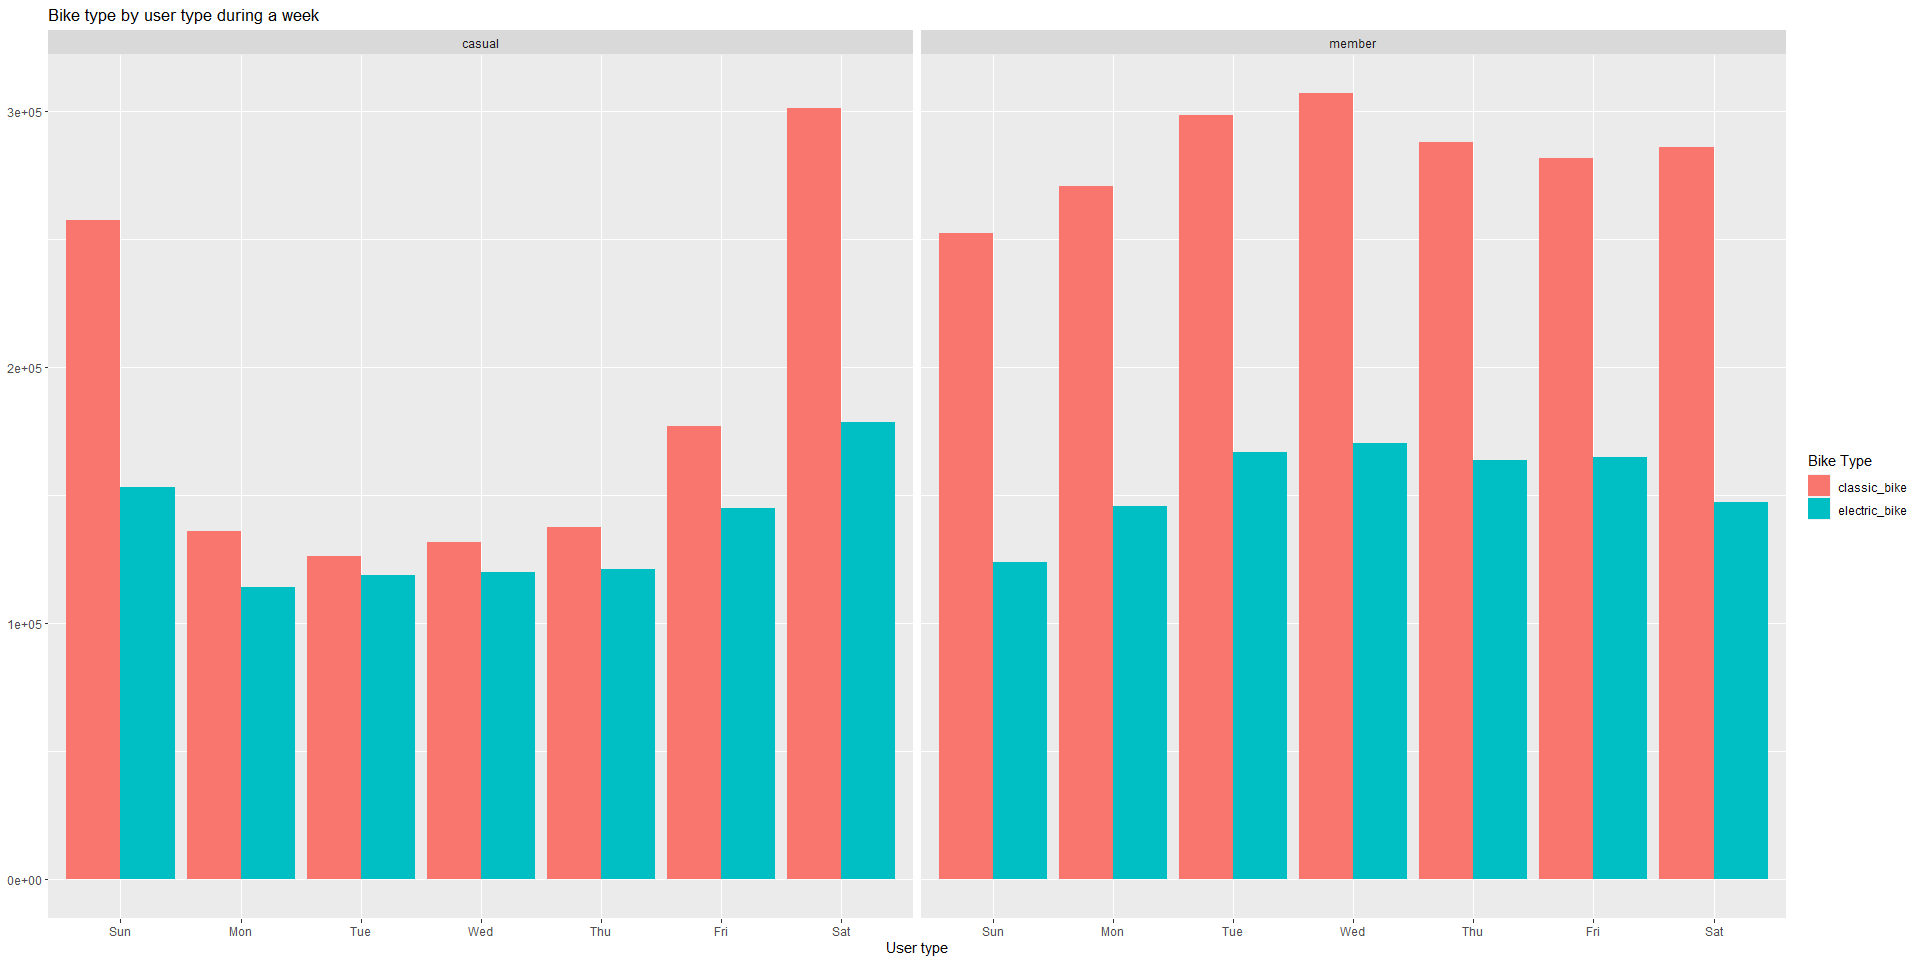

**Conclusions :**
* Over the week we can see that for the annual members there is a small difference of usage between the start of the week, where they prefer the classic bike and the end of the week, where they use more electric bikes.
* For the casual users we see in general the same pattern of usage from the previous weekly charts, preferring the electric vs the classic bikes and having a weekend usage of the service.

**6)** ***Most popular staion and rides by user-type on map***
* First all the null coordiantes are dropped.
* Then round trip routes are ommited from the analysis (although we know from SQL analysis that they form the majority of popular casual routes) as they are hard to visualize on map.
* Trips routes having more than 250 rides are selected for viz.

In [26]:
coordinates_table <- tripdata_2021 %>%
                drop_na(start_lng, start_lat, end_lng, end_lat) %>%
                filter(start_lng != end_lng & start_lat != end_lat) %>%
                group_by(start_lng, start_lat, end_lng, end_lat, member_casual, rideable_type) %>%
                summarise(total = n(), .groups = "drop") %>%
                filter(total > 250)

* The coordinate table is then filtered into different member and casual coordinates that will be furthered used in the map object generation.

In [27]:
casual_coord <- coordinates_table %>% filter(member_casual == "casual")
member_coord <- coordinates_table %>% filter(member_casual == "member")

* Chicago bbox are selected as per the half of the screen ratio from [bboxfinder.com](http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000).

In [28]:
chicago_box <- c(left = -87.812691, bottom = 41.780273, right = -87.541122, top = 41.983994)

* The ggmap package is installed and then loaded.
* A Chicago statenmap of terrain type is made.

In [29]:
install.packages("ggmap")
library(ggmap)
chicago_stamenmap <- get_stamenmap(bbox = chicago_box, zoom = 12, maptype = "terrain")

* The casual and member maps are created on top of the Chicago staten map.

In [30]:
casual_map <- ggmap(chicago_stamenmap, darken = c(0.4, "white")) +
            geom_curve(casual_coord, mapping = aes(x = start_lng, y = start_lat, xend = end_lng, yend = end_lat, color=rideable_type), size = 0.5, curvature = .2,arrow = arrow(length=unit(0.2,"cm"), ends="first", type = "closed")) +
            coord_cartesian() +
            labs(title = "Most popular routes by casual users",x = NULL,y = NULL, color="User type") +
            theme(legend.position="none")

member_map <- ggmap(chicago_stamenmap, darken = c(0.4, "white")) +
            geom_curve(member_coord, mapping = aes(x = start_lng, y = start_lat, xend = end_lng, yend = end_lat, color=rideable_type), size = 0.5, curvature = .2,arrow = arrow(length=unit(0.2,"cm"), ends="first", type = "closed")) +  
            coord_cartesian() +
            labs(title = "Most popular routes by annual members",x = NULL,y = NULL) +
            theme(legend.position="none")

* Both of the plots are placed side-by-side with the grid.arrange function.

In [31]:
library(gridExtra)

grid.arrange(casual_map, member_map, ncol=2)

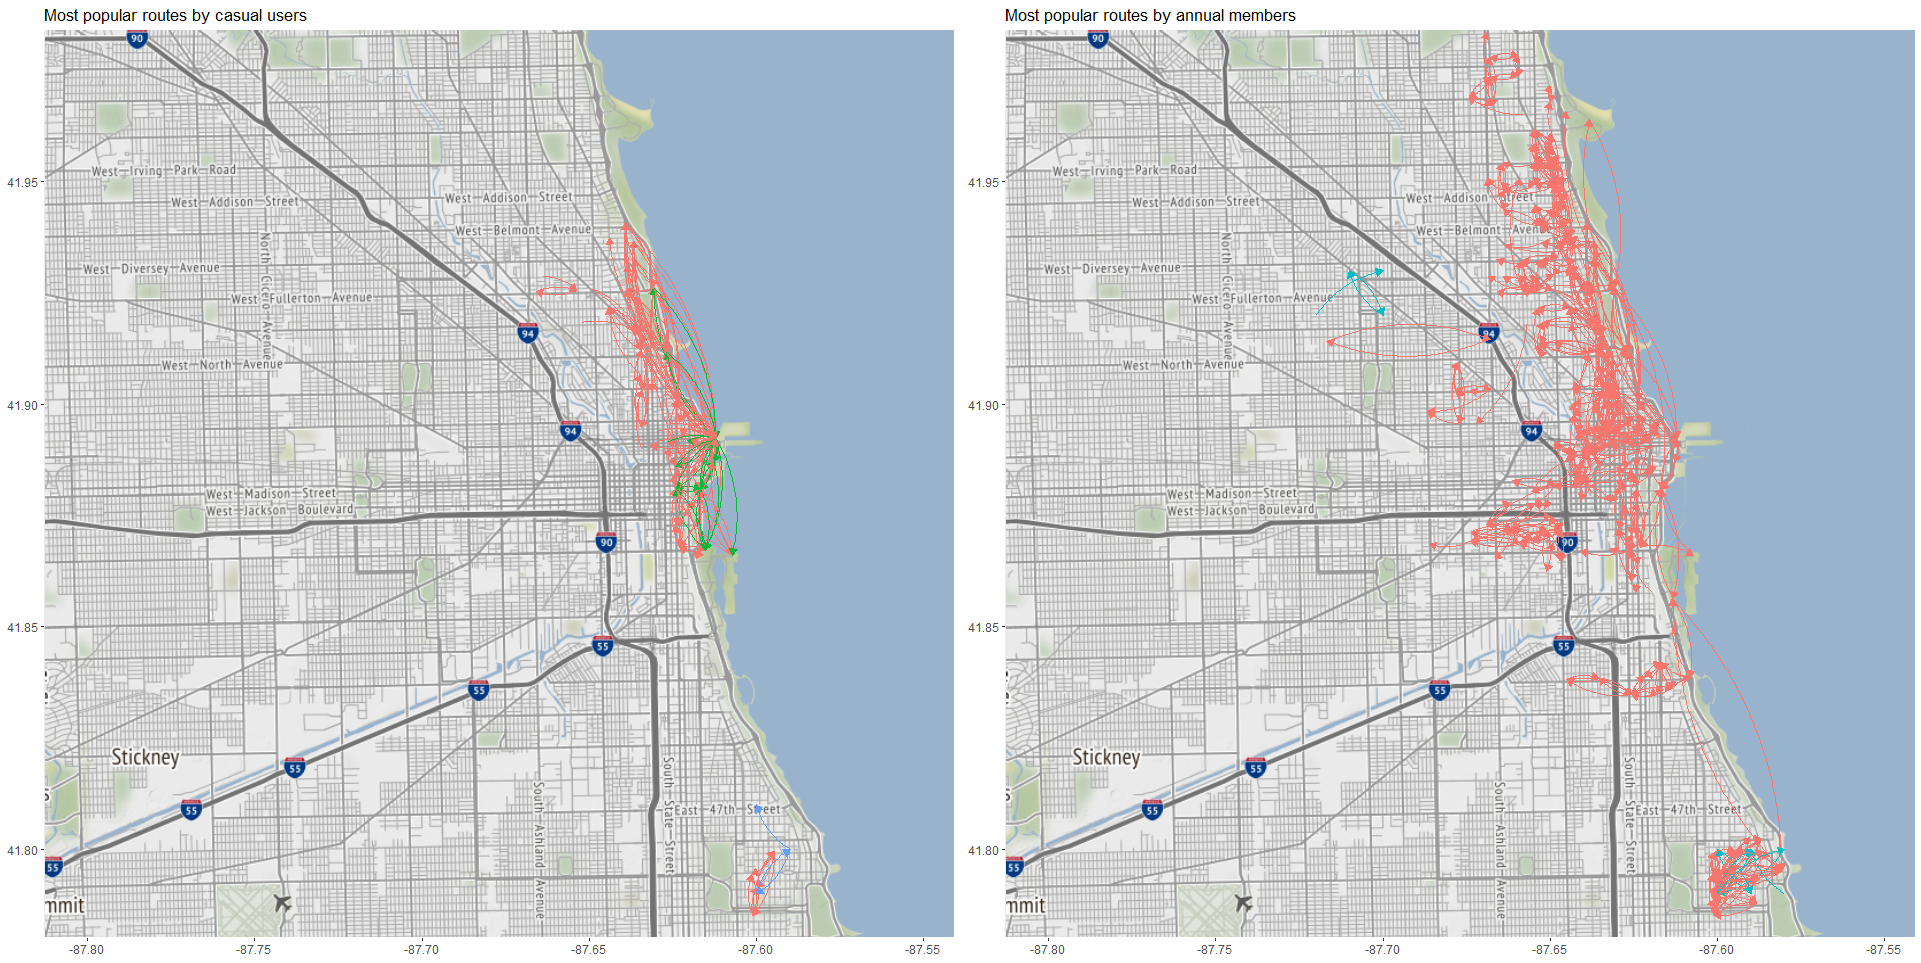

**Conclusions :**
* The coordinates data resulted to be very interesting, as we can clearly see the casual is usually located around the center of the town, with all their trips located around that area which makes sense given that they have a more relaxed leisure rides, on weekends probably also tourist or sightseeing related rides, that naturally focus more on the downtown area where most of the interest points are.
* This contrasts heavily with the longer range of the annual users that connect the downtown with the outskirts of the city, that would suggest they are mostly people that live outside the downtown and use the service to commute everyday to their works in the city.
* For members, there is a particular area with dense rides, and that is the university, which shows that a large proportion of members are university students. Here, the amount of electric bikes used are comparable to that of classic bikes, as most of the trips are very short.
* Also, for casual riders, docked bikes are mostly used while around Chicago harbour.